# Sequence Alignment

Sequence aligment is a fancy way of saying sequence comparison, since it determines the **similarity** of two sequences, by computing its distance or score.

The **sequence aligment recipe** to be able to perform one is the follwing:

**EDIT OPERATIONS**

- **Match (M)** - two characters are equal
- **Mismatch (X)** - change one character for another
- **Insertion (I)** - add a new character
- **Deletion (D)** - remove an existing character


**DISTANCE FUNCTION**

- It is the cost associated with each one of the transformations. The cost provided by the distance function gives the *similarity* between the sequences.

Sequence alignment is fundamentally a **cost minimization problem**, where we aim to transform one sequence into another using the least expensive combination of edit operations. This is where dynamic programming algorithms, like **Needleman-Wunsch and Smith-Waterman**, come into play.


## Combinatorial search apporach 

Use the combinatorial search approach to find the edit-distance between two stings, in this case, between `BAR`and `BADA`. Remember that:

Using the **sequence aligment recipe** and considering that **pattern** is the first sequence and **text** is the second sequence.

We want to convert pattern into text minimizing a distance function. In the edit-distance case, a match has a cost of 0, and other operations has a cost of 1 ($\{M,X,I,D\} = \{0,1,1,1\}$)



In [1]:
def edit_distance(pattern, text):
    # Recursion base bases
    if len(pattern) == 0:
        distance = len(text)
        return (distance, 'I'*distance)
        
    elif len(text) == 0:
        distance = len(pattern)
        return (distance, 'D'*distance)
        
    else:
        # Match or mismatch
        if pattern[0] == text[0]:
            # Match
            m_cost, m_cigar = edit_distance(pattern[1:], text[1:])
        else:
            # Mismatch
            m_cost, m_cigar = edit_distance(pattern[1:], text[1:])
            m_cost += 1
            
        # Find score for insertion
        i_cost, i_cigar = edit_distance(pattern[:],text[1:])
        i_cost += 1
        # Find score for deletion
        d_cost, d_cigar = edit_distance(pattern[1:],text[:])
        d_cost += 1
        # Find the minimum combination
        min_cost = min(m_cost,i_cost,d_cost)
        if min_cost == m_cost:
            if pattern[0] == text[0]:
                return (m_cost, 'M' + m_cigar)
            else:
                return (m_cost, 'X' + m_cigar)
                
        elif min_cost == i_cost:
            return (i_cost, 'I' + i_cigar)
        else:
            return (d_cost, 'D' + d_cigar)


pattern = "BAR"
text = "BADA"
distance, cigar = edit_distance(pattern, text)
print(f'The distance between {pattern} and {text} is: {distance}')
print(f'The CIGAR is: {cigar}')

The distance between BAR and BADA is: 2
The CIGAR is: MMXI


### Memoization

Even though this is a good way to compute a sequence alignment, the number of recursive calls is very high (897625) since we compute things already solved. To solve this issue, we can use memoization.

The key idea is to memorize all the partial results that we explore, so if the partial result has already been explored, we return the saved value (instead of solving it again).

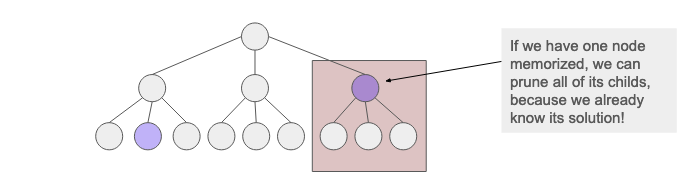


In [2]:
num_calls = 0
saved_calls = {}

def edit_distance(pattern, text):
    global num_calls
    global saved_calls
    
    num_calls += 1
    
    # Check if we already computed the current value
    key = pattern + ':' + text
    if key in saved_calls:
        return saved_calls[key]

    # Recursion base bases
    if len(pattern) == 0:
        return len(text)
        
    elif len(text) == 0:
        return len(pattern)
        
    else:
        # Match or mismatch
        if pattern[0] == text[0]:
            # Match
            m_cost = edit_distance(pattern[1:], text[1:])
        else:
            # Mismatch
            m_cost = edit_distance(pattern[1:], text[1:]) + 1
            
        # Find score for insertion
        i_cost = edit_distance(pattern[:],text[1:]) + 1
        # Find score for deletion
        d_cost = edit_distance(pattern[1:],text[:]) + 1
        # Find the minimum combination
        
        # Save the currently computed partial result
        key = pattern + ':' + text
        saved_calls[key] = min(m_cost,i_cost,d_cost)
        
        return min(m_cost,i_cost,d_cost)


pattern = "BARCELONA"
text = "BADALONA"
distance = edit_distance(pattern, text)
print(f'The distance between {pattern} and {text} is: {distance}')
print(f'The number of calls performed is: {num_calls}')

The distance between BARCELONA and BADALONA is: 3
The number of calls performed is: 217


## Dynamic Programming approach

The dynamic programming approach solves the sequence aligment problem in an efficient way by sistematically computing the aligment costs for all prefixes of the sequences. The results of these computations are stored in a table (the **alignment matrix "M"**). Each cell of ***M_{i,j}*** of this matrix represents the cost of aligning the first 
***i*** characters of a sequence *A* with the first ***j*** characters of a sequence ***B***.

The value of **M_{i,j}** is computed based on three possible operations:

- **Match/Mismatch:** Extending the alignment by comparing the characters A[i] and B[j].
- **Insertion:** Adding a gap in sequence A.
- **Deletion:** Adding a gap in sequence B.

The recurrence relation is:
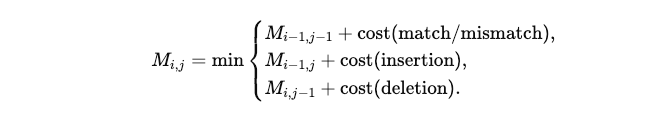

We can either use the ***Needleman-Wunsch Algorithm*** or the ***Smith-Waterman Algorithm***, but we are going to use the first one.


### Needleman-Wunsch Algorithm

The Needleman-Wunsch algorithm is a global alignment algorithm designed to align two sequences end-to-end. It is best suited for cases where the sequences are expected to have comparable lengths and alignment across their entire lengths is meaningful.

Key features:

- **Initialization:** The first row and column of the matrix are initialized based on gap penalties, reflecting the cost of aligning a sequence entirely with gaps.
- **Scoring:** Matches are rewarded (low cost), and mismatches or gaps incur penalties (higher cost).
- **Traceback**: After filling the matrix, the optimal alignment path is traced back from the bottom-right corner to reconstruct the alignment.




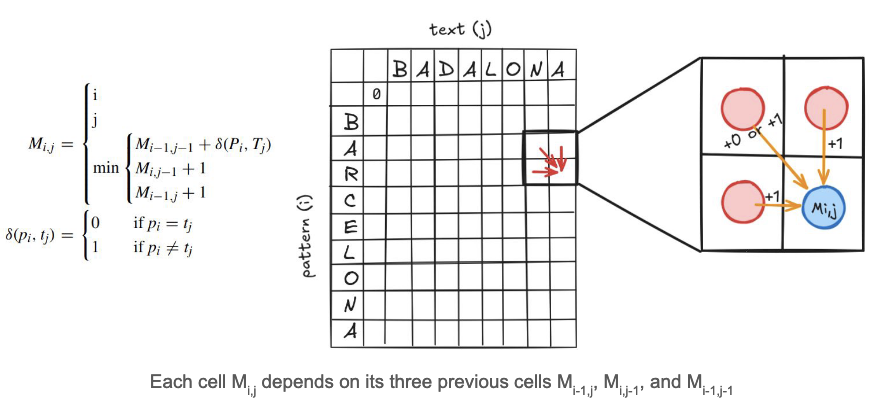

According to this algorithm, we are will create a script that builds and fills a dynamic programming (DP) matrix to calculate the edit distance, then performs a backtrace to reconstruct the alignment.

?the `pprint_matrix function`, prints the dynamic programming matrix in a human-readable way


In [3]:
def pprint_matrix(M, pattern, text):
    try:
        if (len(pattern) + 1 != len(M)) or (len(text) + 1 != len(M[0])):
            raise Exception('Invalid matrix dimensions')
        # Print first row
        print('    ', end='')
        for idx in range(len(M[0]) - 1):
            print(text[idx], end=' ')
    
        print()
            
        for ridx, row in enumerate(M):
            for cidx, col in enumerate(range(len(row)+1)):
                try:
                    if cidx == 0:
                        if ridx == 0:
                            print(' ', end='')
                        else:
                            print(pattern[ridx-1], end='')
                        continue
                    else:
                        print(M[ridx][cidx-1], end='')
                finally:
                    print(' ', end='')
            print()
    except Exception as e:
        print(f'Invalid dynamic programming matrix! Are you sure you are creating the matrix with the correct dimensions?')
        raise e
"""
It takes a filled dynamic programming matrix and the two sequences as input.
Starting at the final cell, it backtraces the path with minimum cost that led to the solution.
Returns a tuple as (distance, cigar). E.g. (3, 'MMXXDMMMM')
"""
def backtrace_dp(M, pattern, text):
    # Start at the final cell
    v = len(pattern)
    h = len(text)

    cigar = ''
    distance = M[v][h]

    # Loop while the are still in the DP matrix
    while v > 0 and h > 0:
        # Check if the current value comes from an upper cell (Deletion)
        if M[v][h] == M[v-1][h] + 1:
            cigar = 'D' + cigar
            v -= 1
        # Check if the current value comes from a left cell (Insertion)
        elif M[v][h] == M[v][h-1] + 1:
            cigar = 'I' + cigar
            h -= 1
        else:
            # Check if the current value comes from a match or a mismatch
            if pattern[v-1] == text[h-1]:
                cigar = 'M' + cigar
            else:
                cigar = 'X' + cigar
            v -= 1
            h -= 1


    # If we end up on a border of the DP matrix, add the remaining CIGAR (insertions or deletions)
    if v > 0:
        cigar = 'D'*v + cigar
    if h > 0:
        cigar = 'I'*h + cigar

    return (distance, cigar)


def edit_distance_dp(pattern, text):
    # Initialize the DP Matrix (M)
    
    m = len(pattern)
    n = len(text)
    M = [[0] * (n + 1) for _ in range(m + 1)]
    
    print('Dynamic programming matrix initialized:')
    pprint_matrix(M, pattern, text)

    # Initialize the first column
    for i in range(m + 1):
        M[i][0] = i

    # Initialize the first row
    for j in range(n + 1):
        M[0][j] = j

    print('M matrix after initializing the first column and row:')
    pprint_matrix(M, pattern, text)
    
    # Fill the rest of the DP matrix with the appropriate costs
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if pattern[i - 1] == text[j - 1]:
                num = 0  # No penalty for match
            else:
                num = 1  # Penalty for mismatch

            insertion = M[i - 1][j]
            deletion = M[i][j - 1]
            mismatch_match = M[i - 1][j - 1]

            M[i][j] = min(insertion + 1, deletion + 1, mismatch_match + num)

    print('After filling the M matrix:')
    pprint_matrix(M, pattern, text)

    # Call backtrace_dp to get the distance and cigar
    return backtrace_dp(M, pattern, text)

# Test the code
pattern = 'BARCELONA'
text = 'BADALONA'

distance, cigar = edit_distance_dp(pattern, text)

print(f'The distance between {pattern} and {text} is: {distance}')
print(f'The cigar is: {cigar}')


Dynamic programming matrix initialized:
    B A D A L O N A 
  0 0 0 0 0 0 0 0 0 
B 0 0 0 0 0 0 0 0 0 
A 0 0 0 0 0 0 0 0 0 
R 0 0 0 0 0 0 0 0 0 
C 0 0 0 0 0 0 0 0 0 
E 0 0 0 0 0 0 0 0 0 
L 0 0 0 0 0 0 0 0 0 
O 0 0 0 0 0 0 0 0 0 
N 0 0 0 0 0 0 0 0 0 
A 0 0 0 0 0 0 0 0 0 
M matrix after initializing the first column and row:
    B A D A L O N A 
  0 1 2 3 4 5 6 7 8 
B 1 0 0 0 0 0 0 0 0 
A 2 0 0 0 0 0 0 0 0 
R 3 0 0 0 0 0 0 0 0 
C 4 0 0 0 0 0 0 0 0 
E 5 0 0 0 0 0 0 0 0 
L 6 0 0 0 0 0 0 0 0 
O 7 0 0 0 0 0 0 0 0 
N 8 0 0 0 0 0 0 0 0 
A 9 0 0 0 0 0 0 0 0 
After filling the M matrix:
    B A D A L O N A 
  0 1 2 3 4 5 6 7 8 
B 1 0 1 2 3 4 5 6 7 
A 2 1 0 1 2 3 4 5 6 
R 3 2 1 1 2 3 4 5 6 
C 4 3 2 2 2 3 4 5 6 
E 5 4 3 3 3 3 4 5 6 
L 6 5 4 4 4 3 4 5 6 
O 7 6 5 5 5 4 3 4 5 
N 8 7 6 6 6 5 4 3 4 
A 9 8 7 7 6 6 5 4 3 
The distance between BARCELONA and BADALONA is: 3
The cigar is: MMXXDMMMM
